In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

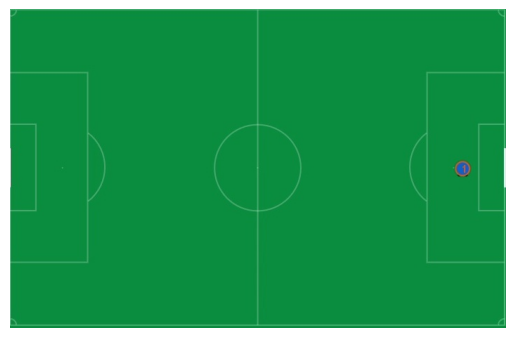

Width: 706 Height: 454


In [3]:
# Load the image
image = cv2.imread('./cropped_images/home_1/frame_0000.jpg')

if image is None:
    print(f"./cropped_images/home_1/frame_0000.jpg")
else:
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

height, width = image.shape[:2]
print("Width:", width, "Height:", height)

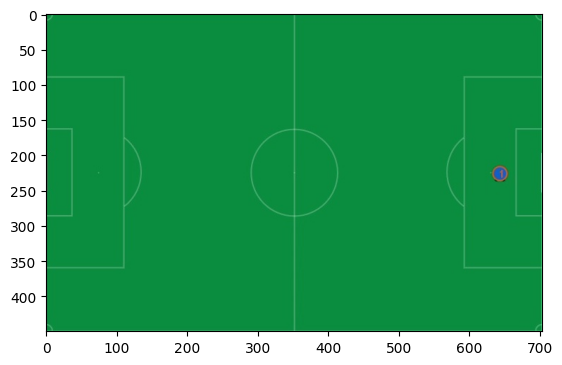

In [4]:
# Minimum size for the players bounding box
MIN_WIDTH = 75
MIN_HEIGHT = 75
MAX_WIDTH = 100
MAX_HEIGHT = 100

# Initialize a list to store player movement
playerCords = []

player_lower = np.array([110,60,50])  # Lower bound for red in BGR
player_upper = np.array([170,130,110])  # Upper bound for red in BGR

# Create masks for player color
player_mask = cv2.inRange(image, player_lower, player_upper)

# Find contours for player
player_contours, _ = cv2.findContours(player_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Process blue players
for contour in player_contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Filter out tiny boxes
    if w < MIN_WIDTH or h < MIN_HEIGHT or w > MAX_WIDTH or h > MAX_HEIGHT:
        continue
    
    # Draw a bounding box
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Blue box 
    
    playerCords.append({
        "color": "Blue",
        "coordinates": (x, y, w, h),
        "raw_x": (x+(w/2)),
        "raw_y": (y+(h/2)),
        "x" : x/width,
        "y" : y/height
    })

# Print the list of players
for player in playerCords:
    print(f"Color: {player['color']},  Raw X: {player['raw_x']}, Raw Y: {player['raw_y']},X: {player['x']}, Y: {player['y']}")
    print(f"Coordinates: {player['coordinates']}")

plt.imshow(image)

In [20]:
# Minimum size for the players bounding box
MIN_WIDTH = 75
MIN_HEIGHT = 75
MAX_WIDTH = 100
MAX_HEIGHT = 100

player_lower = np.array([110,60,50])  # Lower bound for red in BGR
player_upper = np.array([170,130,110])  # Upper bound for red in BGR

def getCoordinates(imagePath,frame_number):
    # Load the image
    image = cv2.imread(imagePath)

    if image is None:
        print("error loading image")
    else:
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]

    # Create masks for player color
    player_mask = cv2.inRange(image, player_lower, player_upper)

    # Find contours for player
    player_contours, _ = cv2.findContours(player_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process blue players
    for contour in player_contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out tiny boxes
        if w < MIN_WIDTH or h < MIN_HEIGHT or w > MAX_WIDTH or h > MAX_HEIGHT:
            continue
        
        # Draw a bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Blue box 
        
        
    return x/width, y/height


In [ ]:
def is_color(hsv_img, mask, lower, upper):
    mean = cv2.mean(hsv_img, mask=mask)[:3]  # 평균 HSV
    return np.all(lower <= mean) and np.all(mean <= upper)

def detect_dual_color_circle(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 50, param1=50, param2=30, minRadius=5, maxRadius=30)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for x, y, r in circles[0, :]:
            mask_center = np.zeros_like(gray)
            cv2.circle(mask_center, (x, y), int(r*0.4), 255, -1)  # 중심 마스크

            mask_ring = np.zeros_like(gray)
            cv2.circle(mask_ring, (x, y), int(r*1.0), 255, -1)
            cv2.circle(mask_ring, (x, y), int(r*0.7), 0, -1)       # 테두리 마스크

            # 색상 범위
            blue_range = (np.array([100, 100, 50]), np.array([130, 255, 255]))
            orange_range = (np.array([10, 100, 100]), np.array([25, 255, 255]))

            if is_color(hsv, mask_center, *blue_range) and is_color(hsv, mask_ring, *orange_range):
                # 조건 만족 원 시각화
                cv2.circle(img, (x, y), r, (0, 255, 0), 2)
                cv2.circle(img, (x, y), 2, (0, 0, 255), 3)
                return x / img.shape[1], y / img.shape[0]

    return np.nan, np.nan

x, y = detect_dual_color_circle("cropped_images/away_3/frame_0334.jpg")
print("원 중심 좌표:", x, y)


원 중심 좌표: nan nan


In [9]:
def detect_circles(image_path):
    # 이미지 읽기
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

     # BGR → HSV 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 파란색 HSV 범위 설정 (필요시 조정)
    lower_blue = np.array([100, 120, 50])
    upper_blue = np.array([140, 255, 255])
    # 주황색 HSV 범위 설정 (필요시 조정)
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([25, 255, 255])
  
    # 주황색 마스크 생성
    mask = cv2.inRange(hsv, lower_orange, upper_orange)
    mask2 = cv2.inRange(hsv, lower_blue, upper_blue)  
    # 마스크 적용
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 2)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    height, width = img.shape[:2]
    # 블러 처리로 노이즈 제거
    gray_blurred = cv2.medianBlur(gray, 5)
    for p2 in [50,40,30]:
    # 허프 원 변환
        circles = cv2.HoughCircles(
            gray_blurred,
            cv2.HOUGH_GRADIENT,
            dp=1.2,         # 해상도 비율
            minDist=100,     # 원 중심 간 최소 거리
            param1=50,      # Canny edge 감도
            param2=p2,      # 원 탐지 임계값
            minRadius=5,    # 탐지할 최소 반지름
            maxRadius=15   # 탐지할 최대 반지름
        )
        #print(type(circles))

        if circles is not None:
            circles = np.uint16(np.around(circles))
            if len(circles[0, :]) > 1: 
                continue
            coords = []
            for c in circles[0, :]:
                x, y, r = c
                coords.append((x, y))
                # 원 그리기 (시각화용)
                cv2.circle(img, (x, y), r, (0, 255, 0), 2)
                cv2.circle(img, (x, y), 2, (0, 0, 255), 3)
                
            
            #시각화 (선택)
            # cv2.imshow("Detected Circles", img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

            return x/width, y/height
        else:
            continue
    return np.nan, np.nan

# 예시 사용
x, y = detect_circles("cropped_images/away_1/frame_0001.jpg")
print("원 중심 좌표:", x, y)


원 중심 좌표: 0.11756373937677053 0.5


In [7]:
players = []
for i in range(1, 12):
    players.append(f'home_{i}')
    players.append(f'away_{i}')
  
output_folder = "./output"
for pl in players:
    input_folder = f"./cropped_images/{pl}"

    playerCords =[]
    image_files = sorted([f for f in os.listdir(input_folder) if f.startswith("frame_")])
    # Iterate through the frame numbers

    for i, filename in enumerate(image_files):  # Range is inclusive    
        # Construct the full path to the image
        image_path = os.path.join(input_folder, filename)
        
        # Check if the file exists (optional but recommended)
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue
        
        w, h=detect_circles(image_path)

        playerCords.append({
                "frame": i,
                "x" : w,
                "y" : h
            })
        

    if 'home' in pl:
        csv_file_name = f"home/{pl}.csv"
    else:
        csv_file_name = f"away/{pl}.csv"
   
    output_path = os.path.join(output_folder, csv_file_name)  # 경로 포함한 파일명

    # Add the "time" column to each dictionary
    for i, item in enumerate(playerCords):
        item['time'] = round(i * 0.04, 2)


    # Write the data to a CSV file
    with open(output_path, mode="w", newline="") as file:
        # Define the CSV writer with fieldnames
        writer = csv.DictWriter(file, fieldnames=["frame", "x", "y", "time"])
        
        # Write the header
        writer.writeheader()
        
        # Write the rows
        writer.writerows(playerCords)

    print(f"Data has been written to {csv_file_name}")

Data has been written to home/home_1.csv
Data has been written to away/away_1.csv
Data has been written to home/home_2.csv
Data has been written to away/away_2.csv
Data has been written to home/home_3.csv
Data has been written to away/away_3.csv
Data has been written to home/home_4.csv
Data has been written to away/away_4.csv
Data has been written to home/home_5.csv
Data has been written to away/away_5.csv
Data has been written to home/home_6.csv
Data has been written to away/away_6.csv
Data has been written to home/home_7.csv
Data has been written to away/away_7.csv
Data has been written to home/home_8.csv
Data has been written to away/away_8.csv
Data has been written to home/home_9.csv
Data has been written to away/away_9.csv
Data has been written to home/home_10.csv
Data has been written to away/away_10.csv
Data has been written to home/home_11.csv
Data has been written to away/away_11.csv
